In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/power-demand-data/demand_Data.csv
/kaggle/input/weather-data/finWeatherData.csv


In [52]:
df_weather =  pd.read_csv("/kaggle/input/weather-data/finWeatherData.csv",index_col = 0,parse_dates=True)

In [53]:
df_weather.head()

,Date,Tmax,Tmin,Rain
0,2019-01-01,28.696802,14.070121,0.0
1,2019-01-02,29.149151,14.778795,0.0
2,2019-01-03,29.741541,15.863366,0.0
3,2019-01-04,29.451434,16.492335,0.0
4,2019-01-05,28.863384,16.951641,0.0


In [54]:
df_demand = pd.read_csv("/kaggle/input/power-demand-data/demand_Data.csv",parse_dates =True)

In [55]:
df_demand.head()

,Date,Energy Required (MU)
0,02-May-12,255.639
1,03-May-12,258.470
2,04-May-12,261.393
3,05-May-12,252.866
4,06-May-12,250.566


In [56]:

# Convert the date column to datetime format
df_demand['Date'] = pd.to_datetime(df_demand['Date'],errors="coerce", format="%d-%b-%y")

# Convert the date column to the desired format
df_demand['Date'] = df_demand['Date'].dt.strftime("%d/%m/%Y")

In [57]:
import pandas as pd

# Convert the "Date" column in df_energy to datetime format
df_demand['Date'] = pd.to_datetime(df_demand['Date'])

# Filter df_energy to include dates starting from 01/01/2019
df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Convert the "Date" column in df_weather to datetime format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

# Filter df_weather to include dates starting from 01/01/2019
df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Merge the two DataFrames based on the "Date" column
merged_df = pd.merge(df_demand, df_weather, on='Date', how='inner')


/tmp/ipykernel_32/3321147370.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_demand['Date'] = pd.to_datetime(df_demand['Date'])


In [58]:
merged_df

,Date,Energy Required (MU),Tmax,Tmin,Rain
0,2019-01-01,152.233,28.696802,14.070121,0.000000
1,2019-02-01,155.343,29.408003,18.148469,0.000000
2,2019-03-01,157.659,33.184526,23.714411,1.550007
3,2019-04-01,159.317,37.308186,25.592237,0.025442
4,2019-05-01,159.691,36.672354,27.560249,1.480898
...,...,...,...,...,...
1553,2023-03-05,188.591,35.240079,19.384070,0.000000
1554,2023-04-05,193.000,35.972310,25.309858,0.392332
1555,2023-05-05,193.201,33.934335,25.928193,2.541572
1556,2023-05-13,224.030,38.145824,27.398606,0.000000


In [59]:
merged_df = merged_df.set_index("Date")

In [60]:
merged_df.isna().sum()

Energy Required (MU)    0
Tmax                    0
Tmin                    0
Rain                    0
dtype: int64

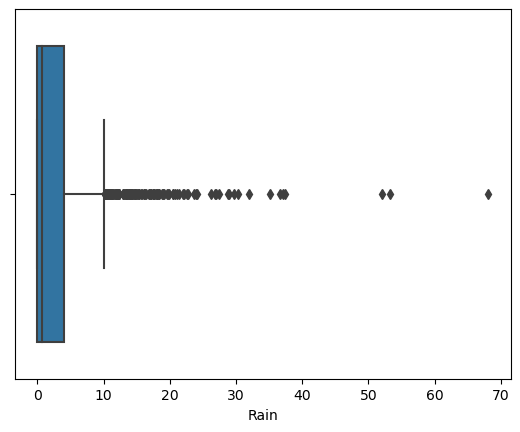

In [61]:
sns.boxplot(x=merged_df['Rain'])
plt.show()

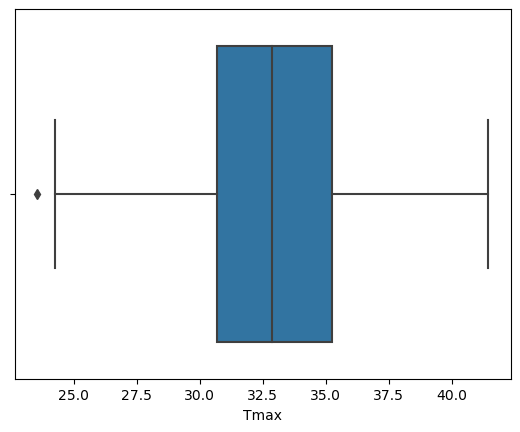

In [62]:
sns.boxplot(x=merged_df['Tmax'])
plt.show()

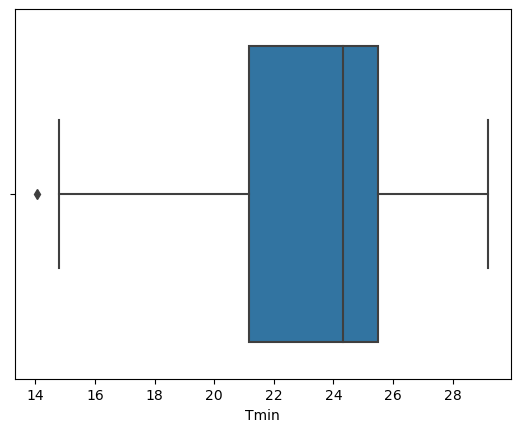

In [63]:
sns.boxplot(x=merged_df['Tmin'])
plt.show()

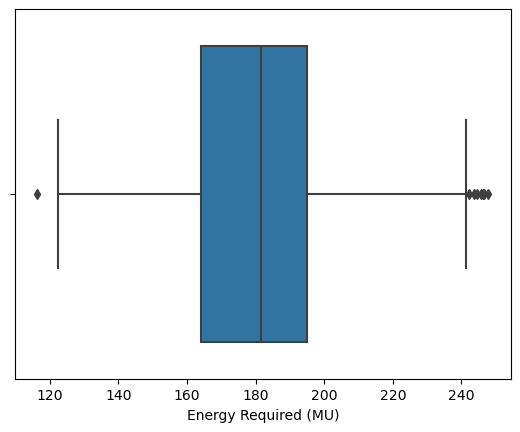

In [64]:
sns.boxplot(x=merged_df['Energy Required (MU)'])
plt.show()

In [65]:
# Convert index to a DatetimeIndex with a frequency
merged_df.index = pd.date_range(start=merged_df.index[0], periods=len(merged_df), freq='D')

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01')])

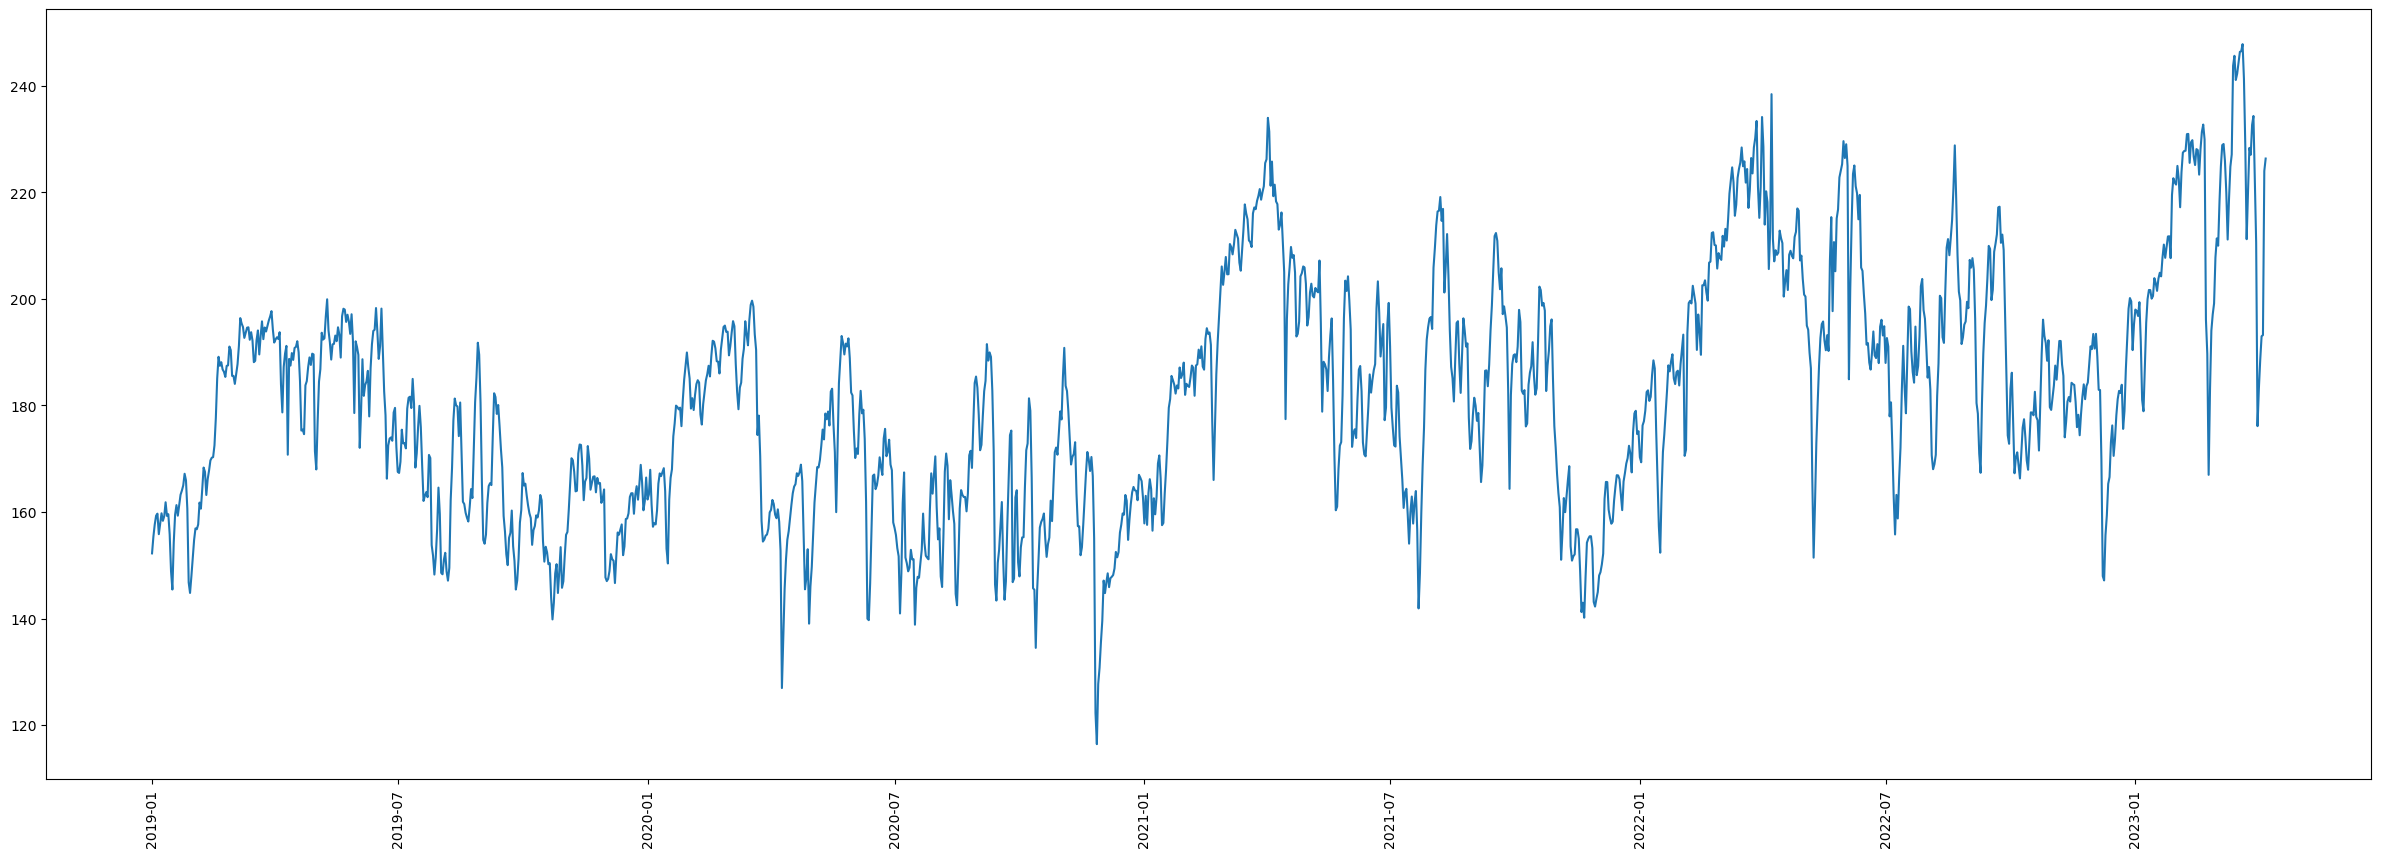

In [66]:
plt.figure(figsize=(30,10))
plt.plot(merged_df["Energy Required (MU)"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01')])

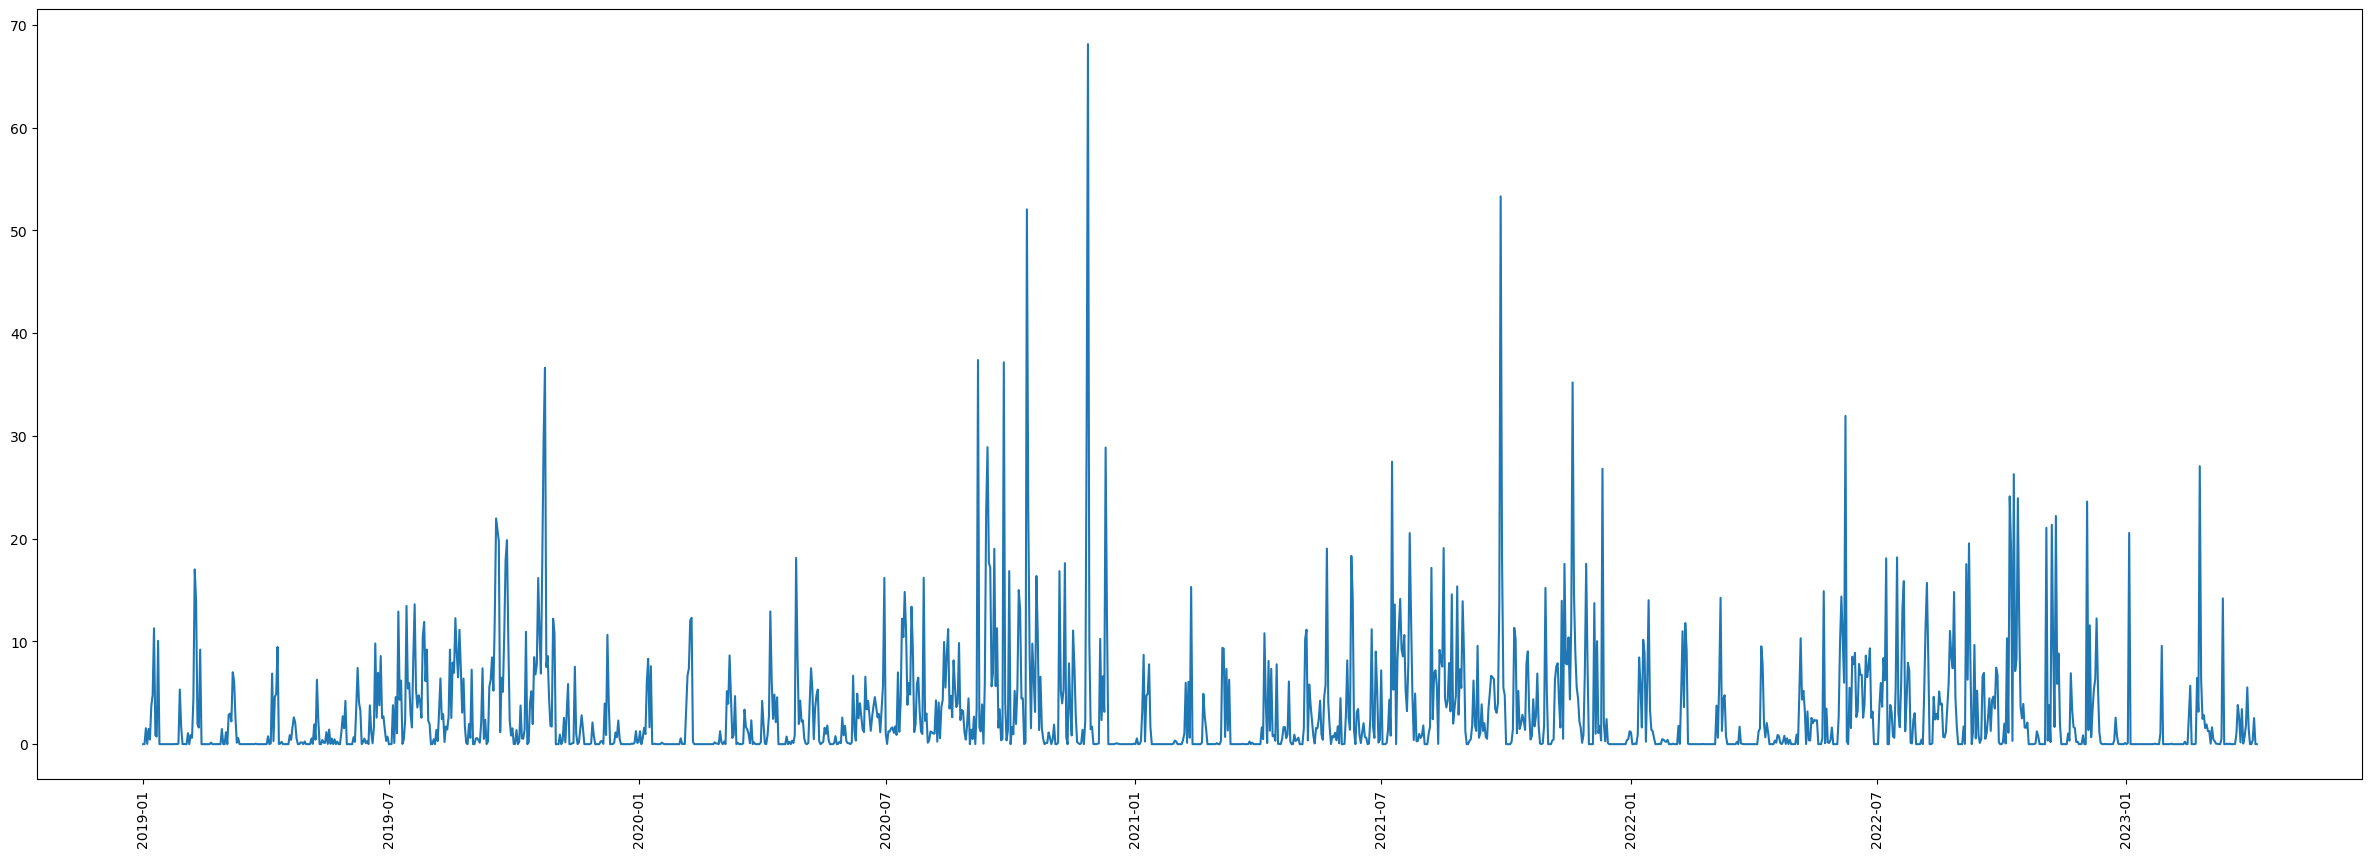

In [67]:
plt.figure(figsize=(30,10))
plt.plot(merged_df["Rain"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01')])

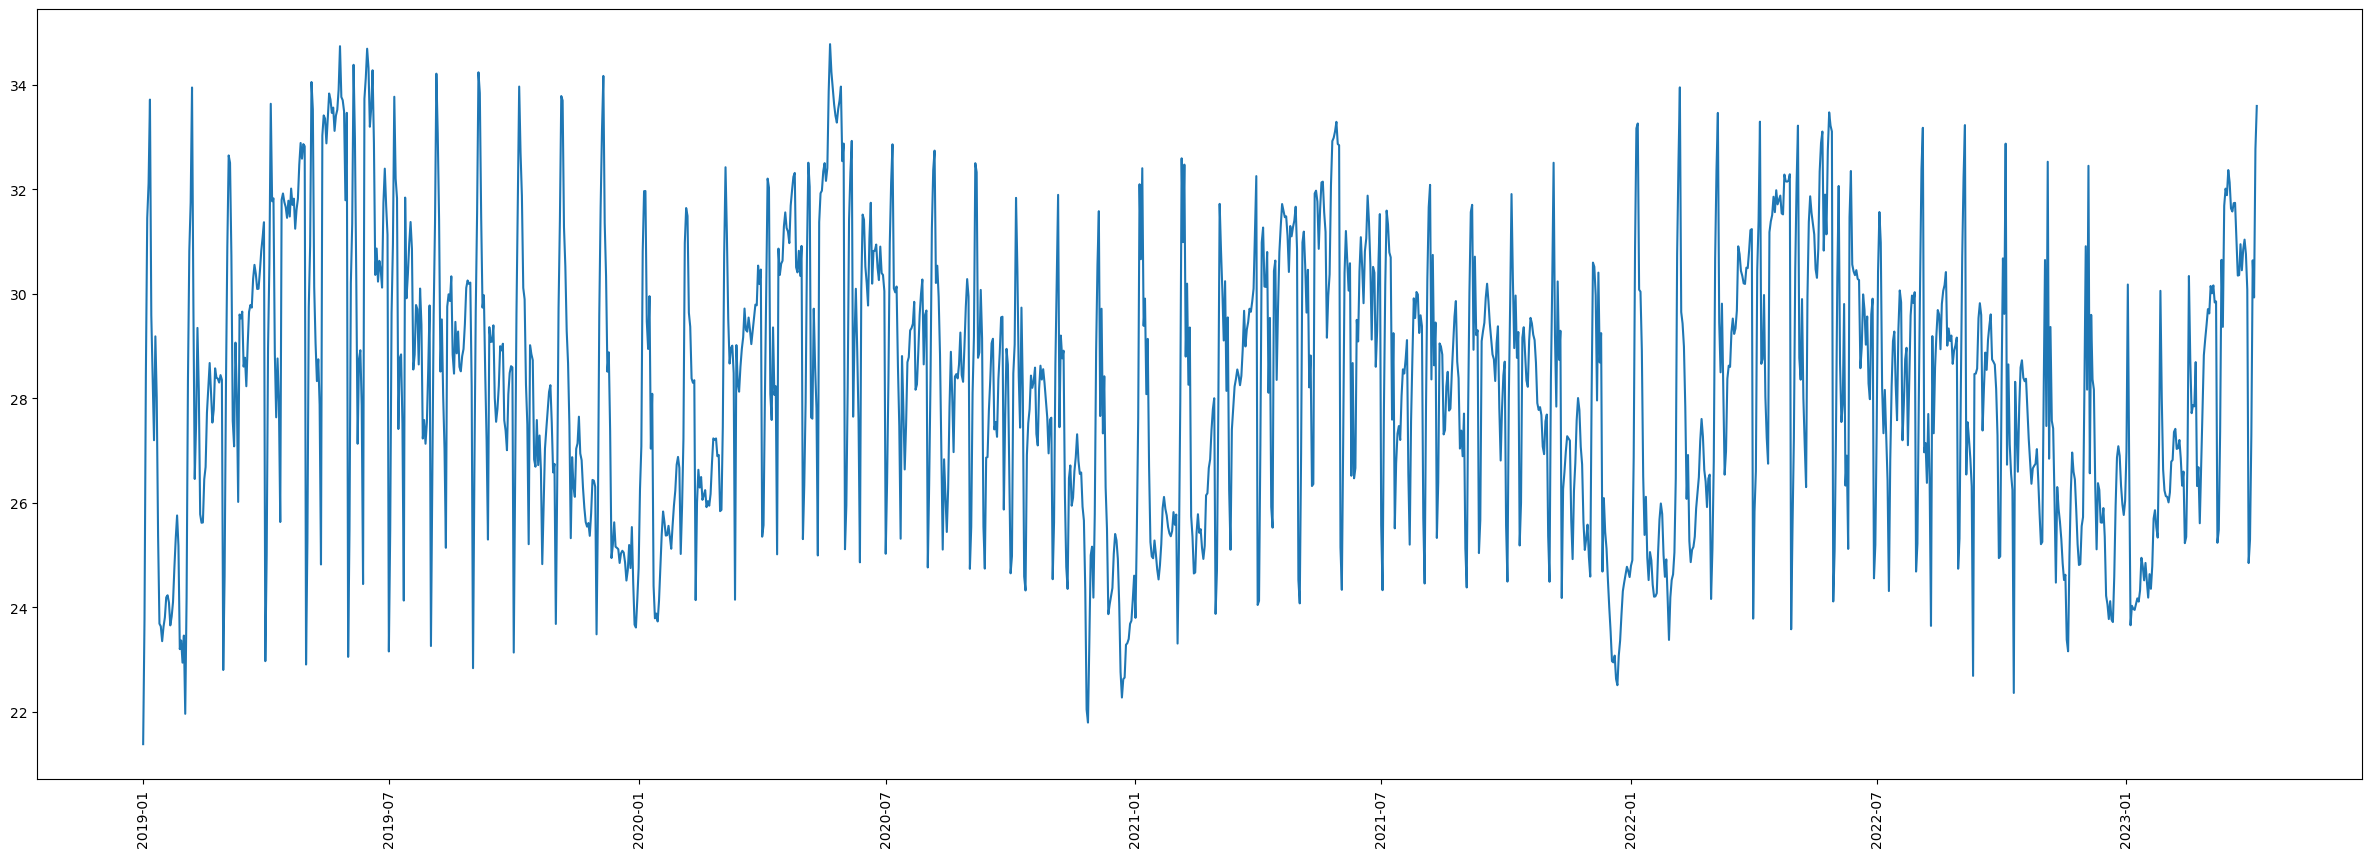

In [68]:
plt.figure(figsize=(30,10))
plt.plot((merged_df["Tmax"]+merged_df["Tmin"])/2)
plt.xticks(rotation=90)

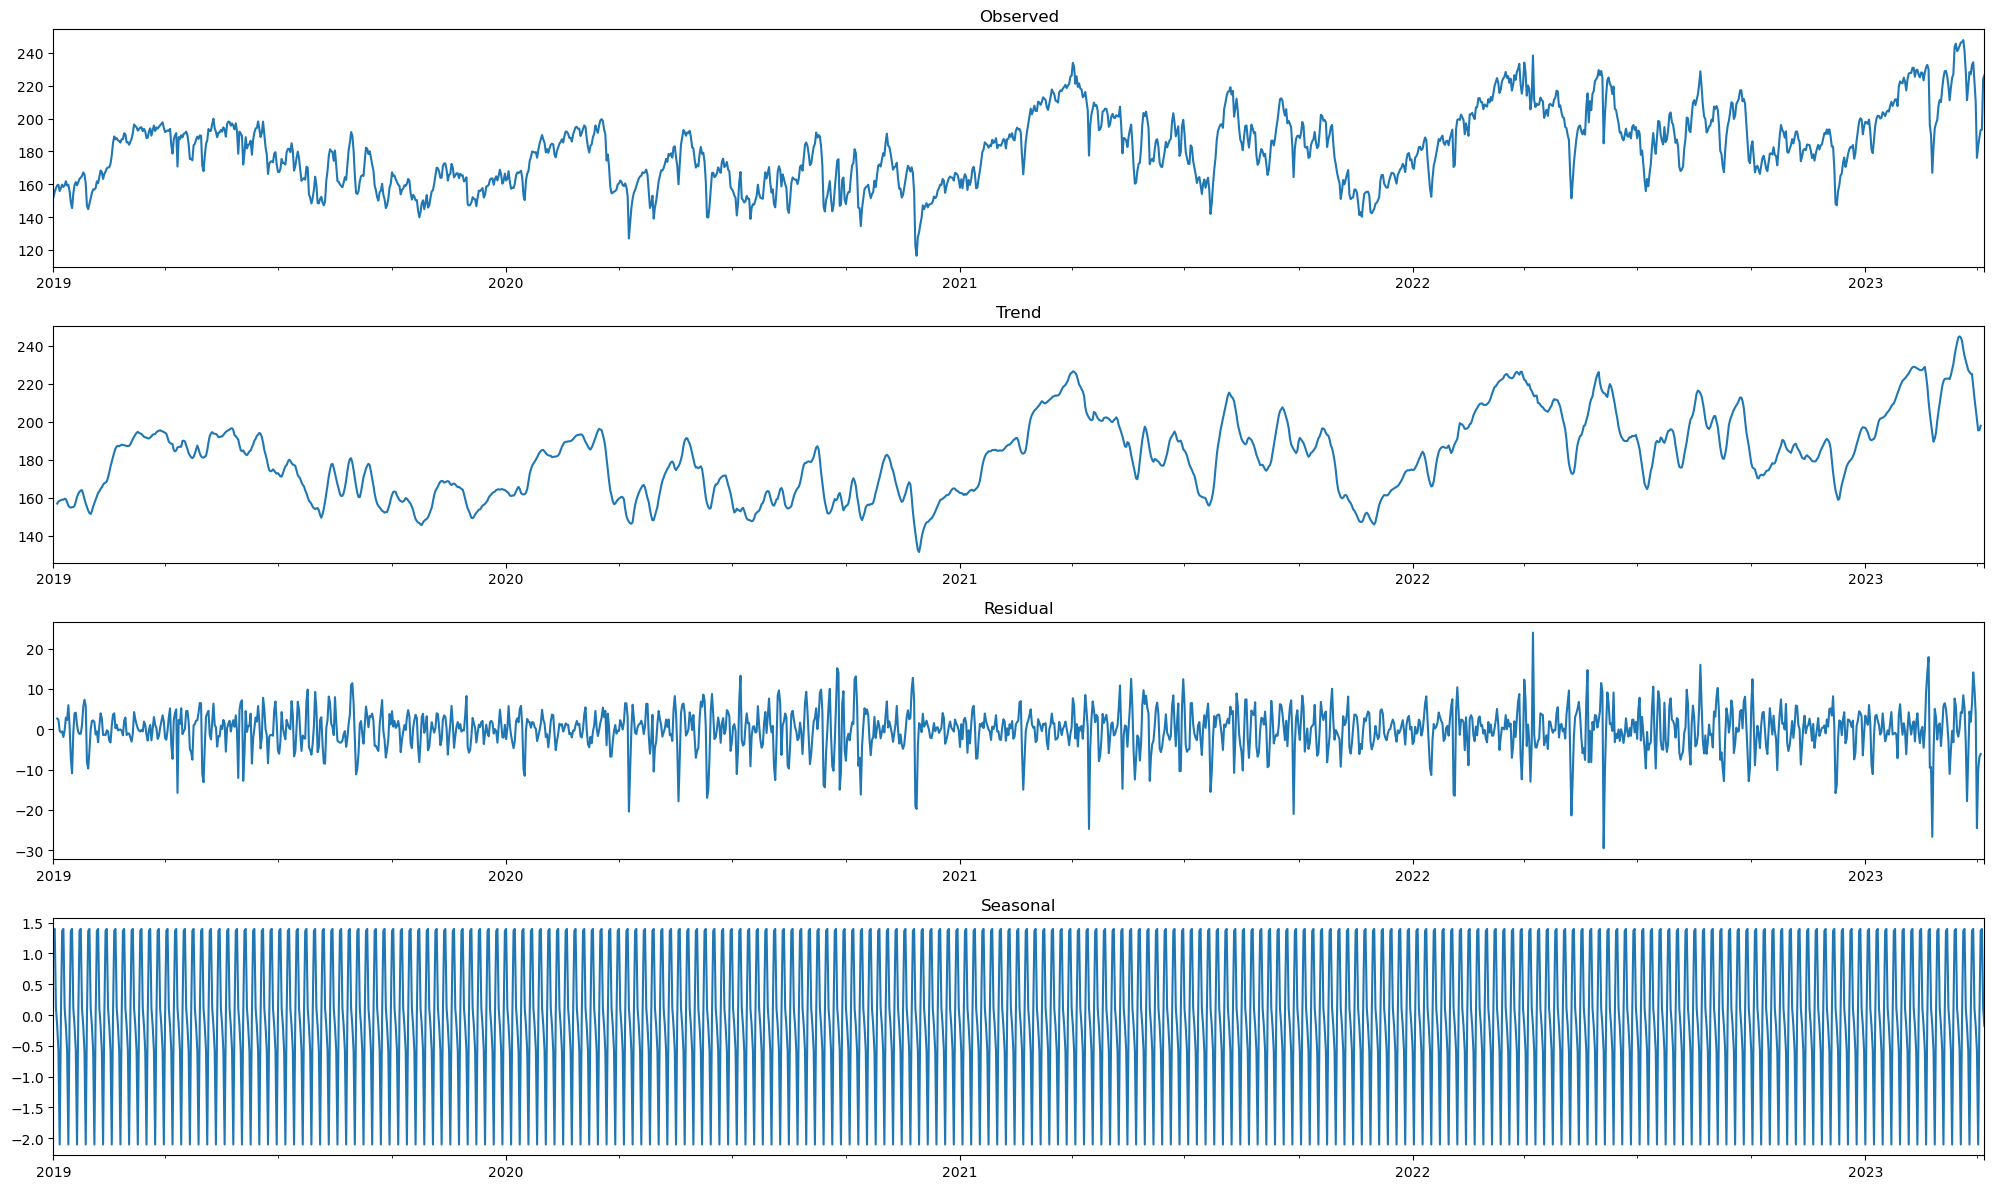

In [69]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Perform seasonal decomposition
res = sm.tsa.seasonal_decompose(merged_df['Energy Required (MU)'], model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [70]:
y = merged_df['Energy Required (MU)']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -3.951004
p-value: 0.001690
#Lags used: 15
Critical Value (1%): -3.434598
Critical Value (5%): -2.863416
Critical Value (10%): -2.567769


The **ADF statistic** (-3.951004) is less than the critical value at 5% (-2.863416) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is **either stationary or could be made stationary** with 1st order differencing (difference-stationary).

In [71]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(y, regression='c')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print(f'Critical value ({key}): {value}')


KPSS Statistic: 1.972154
p-value: 0.010000
#Lags used: 25
Critical value (10%): 0.347
Critical value (5%): 0.463
Critical value (2.5%): 0.574
Critical value (1%): 0.739


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The **KPSS statistic (1.972154)** is higher than the critical value at 5% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 5%**, meaning that the **time series is stationary **or stationary around a constant.

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


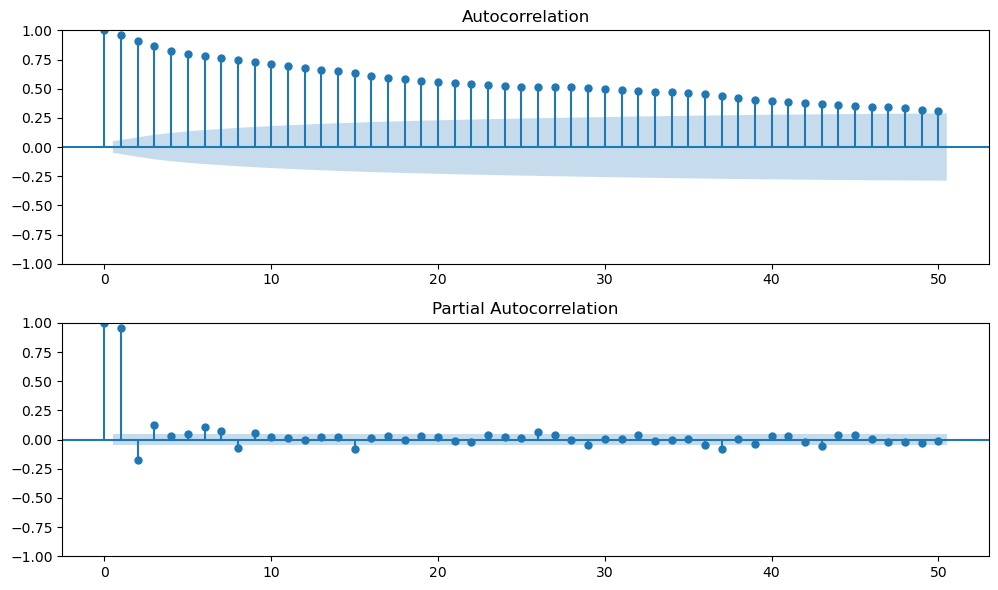

In [72]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(merged_df['Energy Required (MU)'], lags=50, ax=ax1)
plot_pacf(merged_df['Energy Required (MU)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

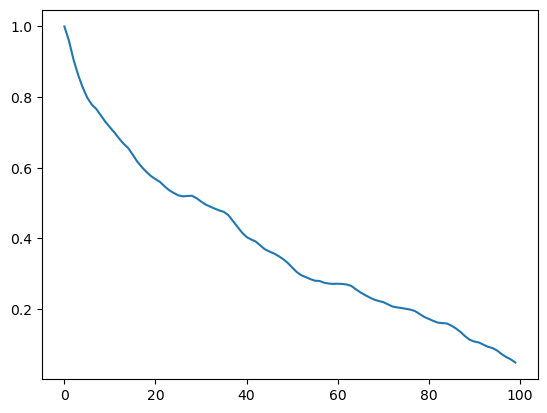

In [73]:
cross_corr = ccf(merged_df['Energy Required (MU)'], merged_df['Energy Required (MU)'])
plt.plot(cross_corr[0:100])
plt.show()

In [74]:
correlations = merged_df.corr(method='pearson')
print(correlations['Energy Required (MU)'].sort_values(ascending=False).to_string())

Energy Required (MU)    1.000000
Tmax                    0.336400
Tmin                    0.081247
Rain                   -0.256393


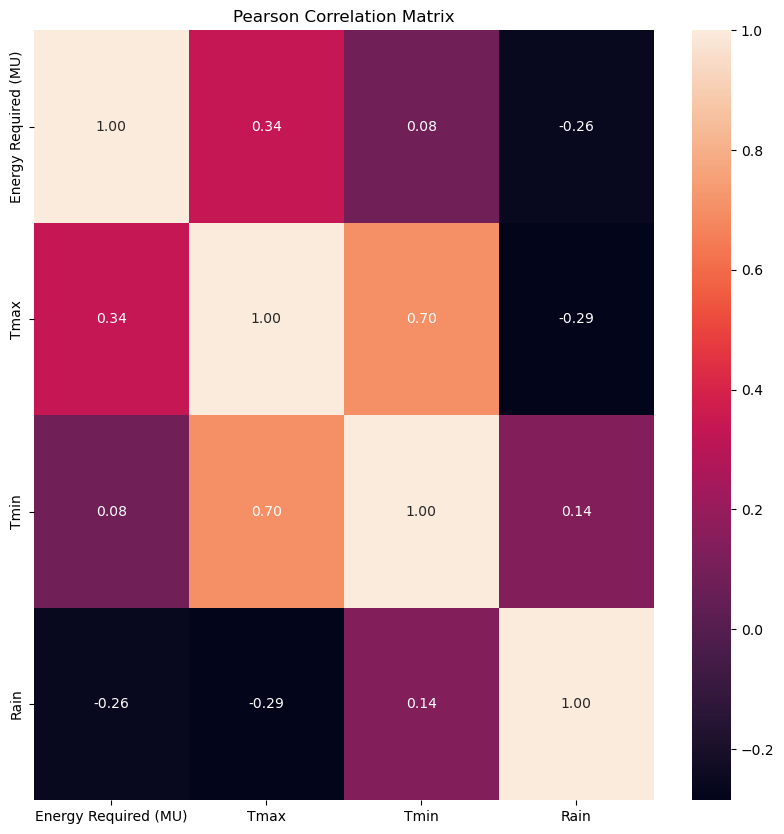

In [75]:

correlations = merged_df.corr(method='pearson')
fig = plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [76]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Series([], )


In [196]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    if start_index == 0:
        start_index = start_index + history_size
    else:
        start_index = start_index
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [197]:
X = merged_df.values
y = merged_df['Energy Required (MU)'].values

In [198]:
X.shape

(1558, 4)

In [199]:
train_end_idx = 1200
cv_end_idx = 1396
test_end_idx = 1557

In [200]:
X

array([[152.233     ,  28.69680159,  14.07012138,   0.        ],
       [155.343     ,  29.40800289,  18.14846943,   0.        ],
       [157.659     ,  33.18452609,  23.71441105,   1.55000675],
       ...,
       [193.201     ,  33.9343353 ,  25.92819331,   2.54157166],
       [224.03      ,  38.14582355,  27.39860641,   0.        ],
       [226.349     ,  39.62275041,  27.56807882,   0.        ]])

In [201]:

y = y.reshape(-1, 1)
y

array([[152.233],
       [155.343],
       [157.659],
       ...,
       [193.201],
       [224.03 ],
       [226.349]])

In [202]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [203]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [204]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [205]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    if start_index==0:
        start_index = start_index + history_size
    else:
        start_index=start_index
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [206]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1)
n_features = 4
past_history = 28
future_target = 1

In [209]:
X_train, y_train = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [210]:
X_train.shape

(1172, 28, 4)

In [211]:
X_val, y_val = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [212]:
X_val.shape

(196, 28, 4)

In [213]:
X_test, y_test = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [214]:
X_test.shape

(161, 28, 4)

In [215]:
batch_size = 32
buffer_size = 1000

In [217]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [218]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [219]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [220]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

# **Vanila LSTM**

In [103]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [104]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
37/37 [==============================] - 3s 35ms/step - loss: 0.0405 - root_mean_squared_error: 0.2011 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1506
Epoch 2/120
37/37 [==============================] - 1s 21ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1382
Epoch 3/120
37/37 [==============================] - 1s 20ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 4/120
37/37 [==============================] - 1s 21ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 5/120
37/37 [==============================] - 1s 20ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1609
Epoch 6/120
37/37 [==============================] - 1s 19ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.0179 - val_

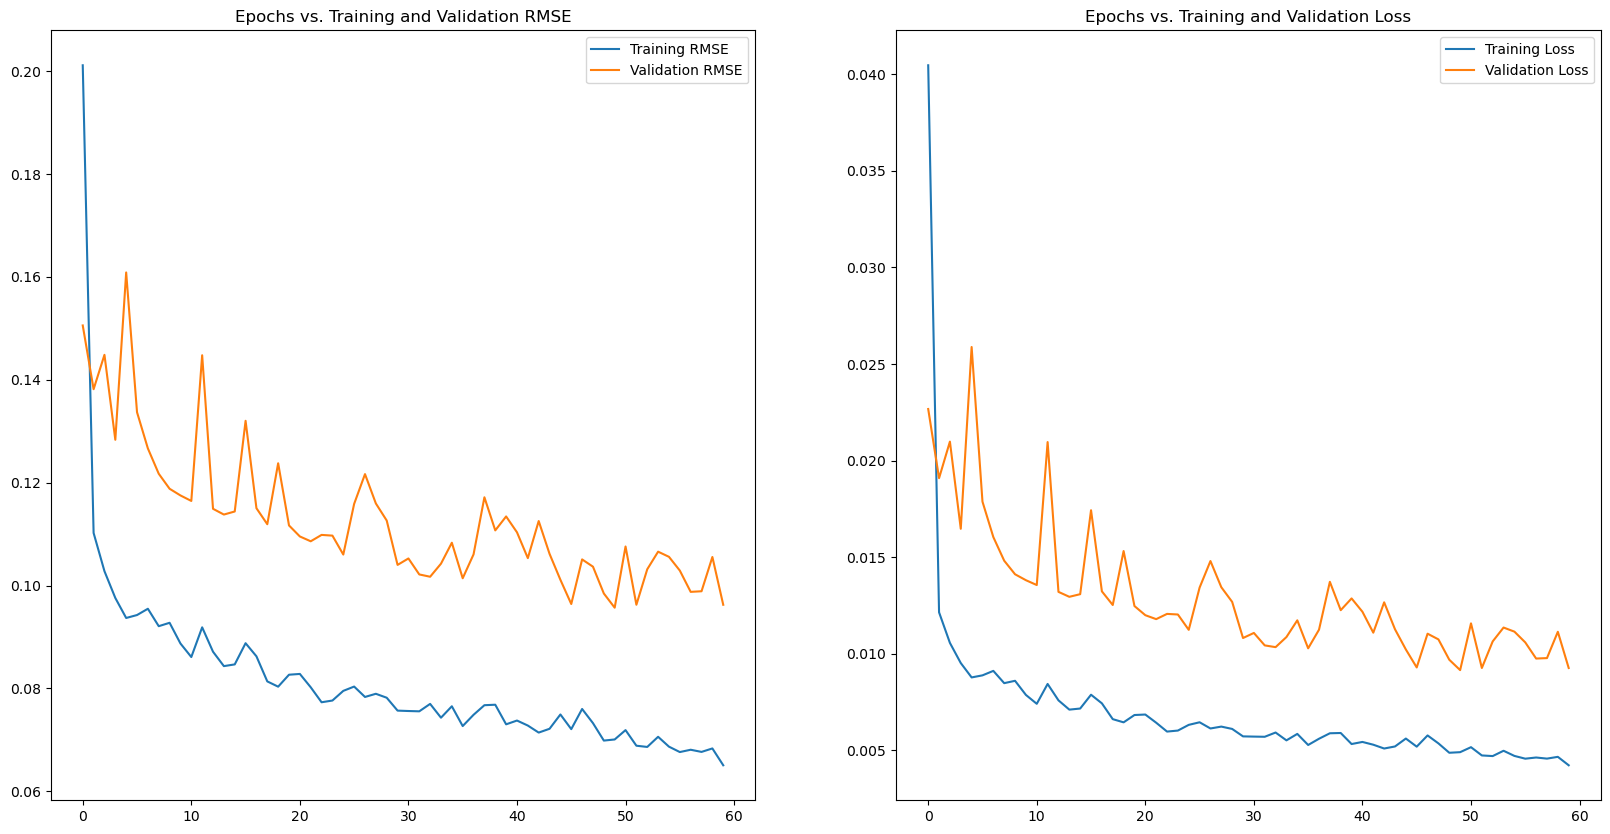

In [105]:
plot_model_rmse_and_loss(history)

In [106]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of day ahead power demand LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

6/6 [==============================] - 0s 6ms/step
RMSE of day ahead power demand LSTM forecast: 10.719


In [174]:
train_forecast = multivariate_lstm.predict(X_train)

train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

37/37 [==============================] - 0s 6ms/step


In [175]:
valid_forecast = multivariate_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

7/7 [==============================] - 0s 6ms/step


In [107]:
merged_df.index[1368:1529]

DatetimeIndex(['2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03',
               '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07',
               '2022-10-08', '2022-10-09',
               ...
               '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08', '2023-03-09'],
              dtype='datetime64[ns]', length=161, freq='D')

In [108]:
len(lstm_forecast)

161

In [246]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[1529:1559]

In [248]:
X_test2 = X[1530:1558,:].reshape(1,past_history,n_features)

In [249]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)

1/1 [==============================] - 0s 332ms/step


In [250]:
lstm_forecast_unseen

array([[1283.8905]], dtype=float32)

In [251]:
len(dates_forecasted)

161

In [252]:

# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

In [253]:
merged_df.tail(4)

,Energy Required (MU),Tmax,Tmin,Rain
2023-04-04,193.000,35.972310,25.309858,0.392332
2023-04-05,193.201,33.934335,25.928193,2.541572
2023-04-06,224.030,38.145824,27.398606,0.000000
2023-04-07,226.349,39.622750,27.568079,0.000000


In [254]:
extended_index[-1:]

DatetimeIndex(['2023-04-08'], dtype='datetime64[ns]', freq=None)

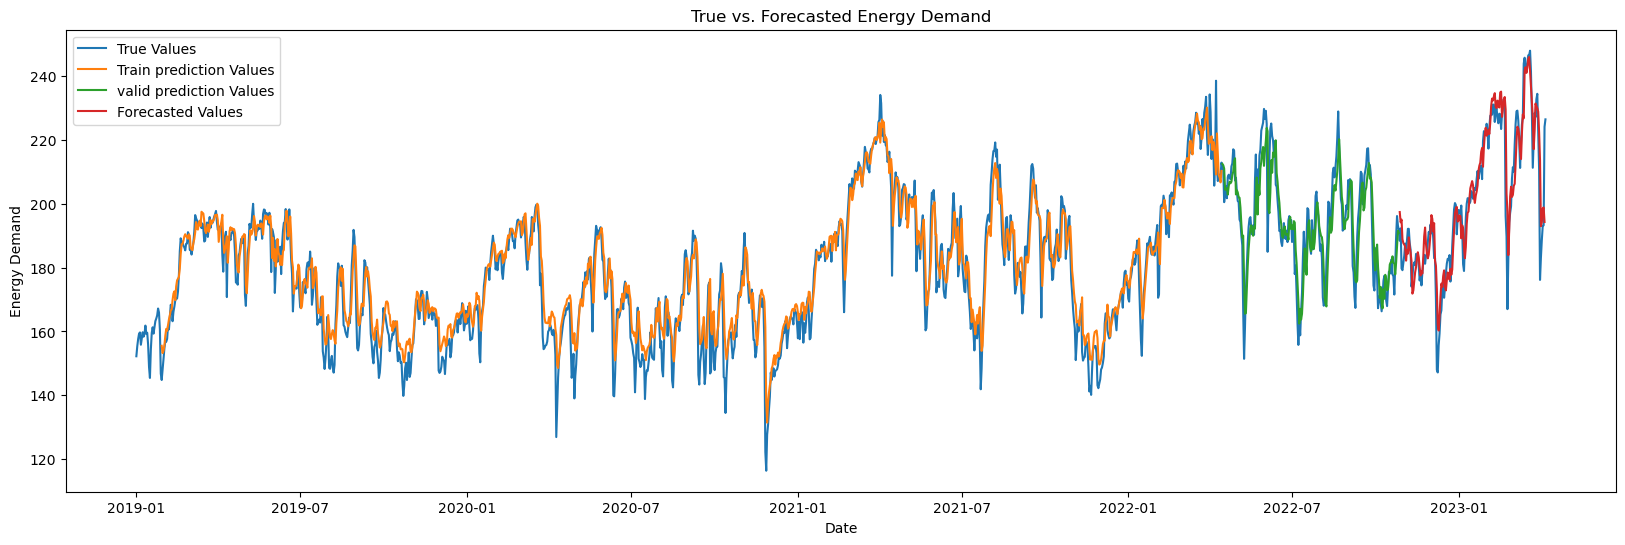

In [255]:
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, true_values[:1559], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Stacked LSTM**

In [117]:
tf.keras.backend.clear_session()

from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, LeakyReLU

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, return_sequences=True),
    LSTM(200, return_sequences=True),
    LSTM(150, return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(50),
    Flatten(),
    Dense(150),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [118]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
37/37 [==============================] - 14s 181ms/step - loss: 0.0340 - root_mean_squared_error: 0.1745 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 2/120
37/37 [==============================] - 5s 133ms/step - loss: 0.0156 - root_mean_squared_error: 0.1251 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1573
Epoch 3/120
37/37 [==============================] - 5s 128ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 4/120
37/37 [==============================] - 5s 130ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1819
Epoch 5/120
37/37 [==============================] - 5s 136ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1453
Epoch 6/120
37/37 [==============================] - 5s 129ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.0297

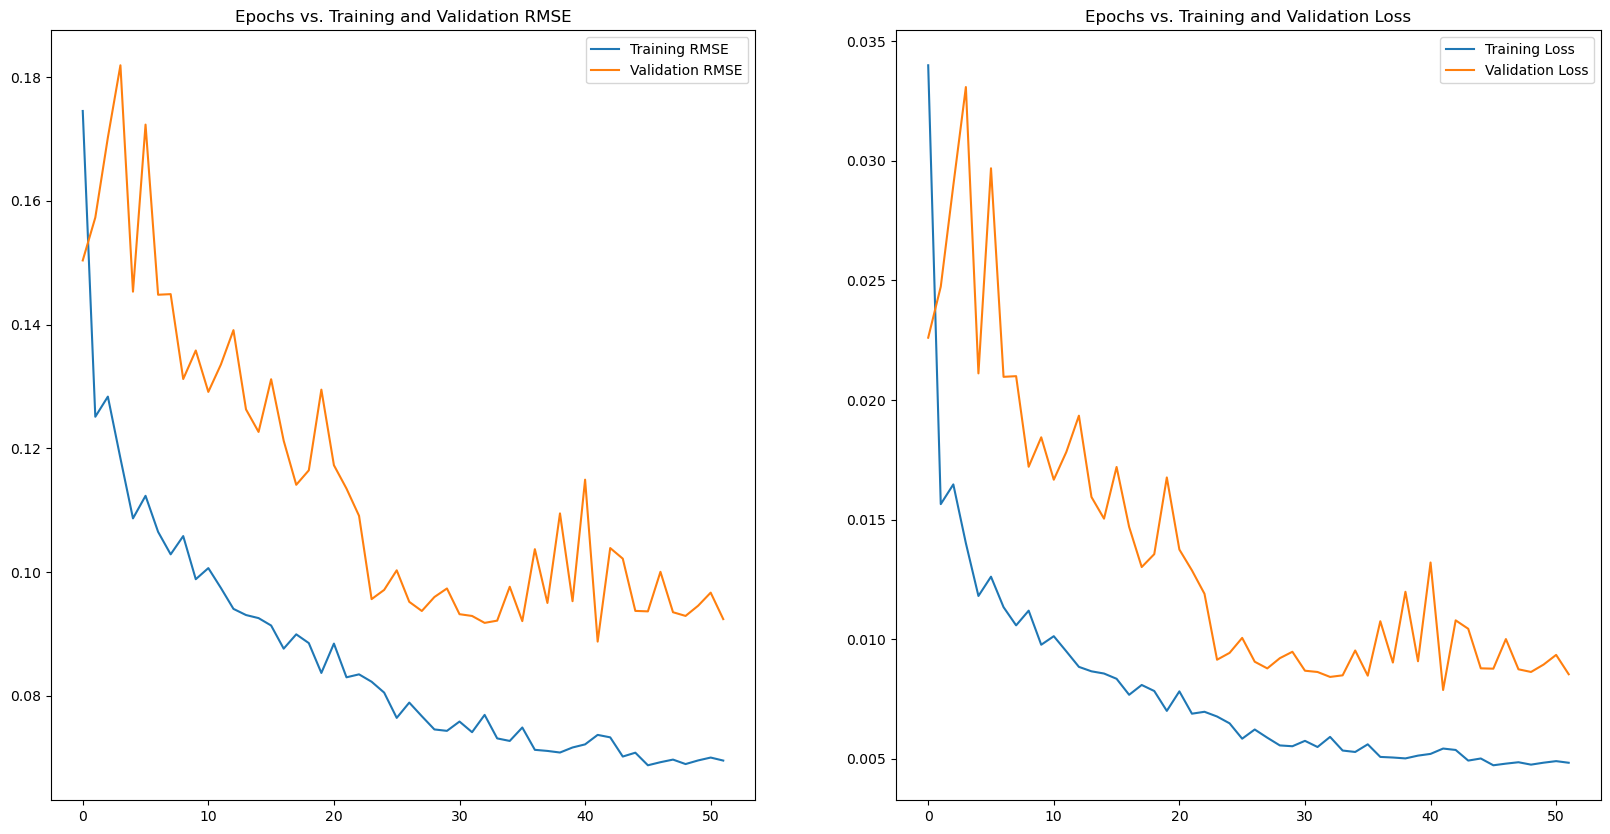

In [119]:
plot_model_rmse_and_loss(history)

In [120]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of day ahead power demand multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


6/6 [==============================] - 2s 35ms/step
RMSE of day ahead power demand multivariate Stacked LSTM forecast: 11.08


In [245]:
merged_df.index[1368:1529]

DatetimeIndex(['2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03',
               '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07',
               '2022-10-08', '2022-10-09',
               ...
               '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08', '2023-03-09'],
              dtype='datetime64[ns]', length=161, freq='D')

In [256]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[1529:1559]

train_forecast = multivariate_stacked_lstm.predict(X_train)

train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

valid_forecast = multivariate_stacked_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

7/7 [==============================] - 0s 42ms/step


In [257]:
n_features = 4

In [258]:
X_test2 = X[1530:1558,:].reshape(1,past_history,n_features)

In [259]:
multivariate_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)

1/1 [==============================] - 1s 1s/step


In [260]:

# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

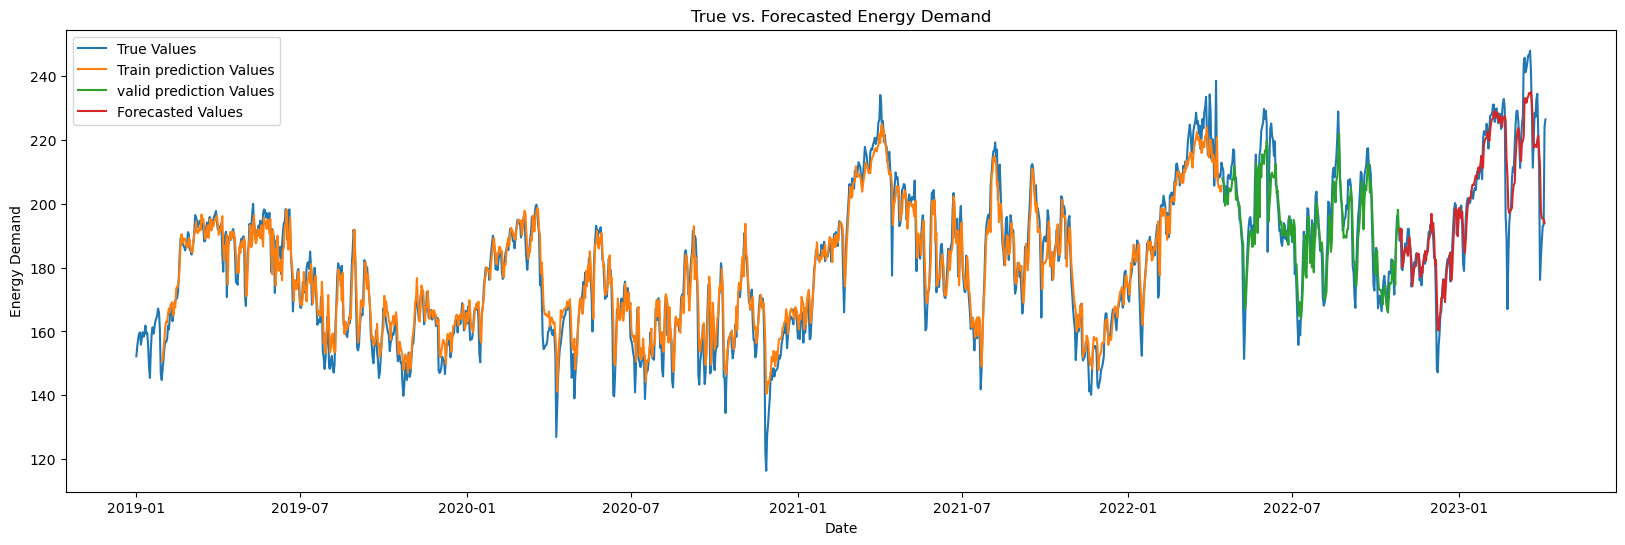

In [261]:
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, true_values[:1559], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_stacked_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN**

In [127]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [128]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
37/37 [==============================] - 1s 6ms/step - loss: 0.0357 - root_mean_squared_error: 0.1785 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 2/120
37/37 [==============================] - 0s 3ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1288
Epoch 3/120
37/37 [==============================] - 0s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1381
Epoch 4/120
37/37 [==============================] - 0s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 5/120
37/37 [==============================] - 0s 3ms/step - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 6/120
37/37 [==============================] - 0s 2ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0188 - val_root_m

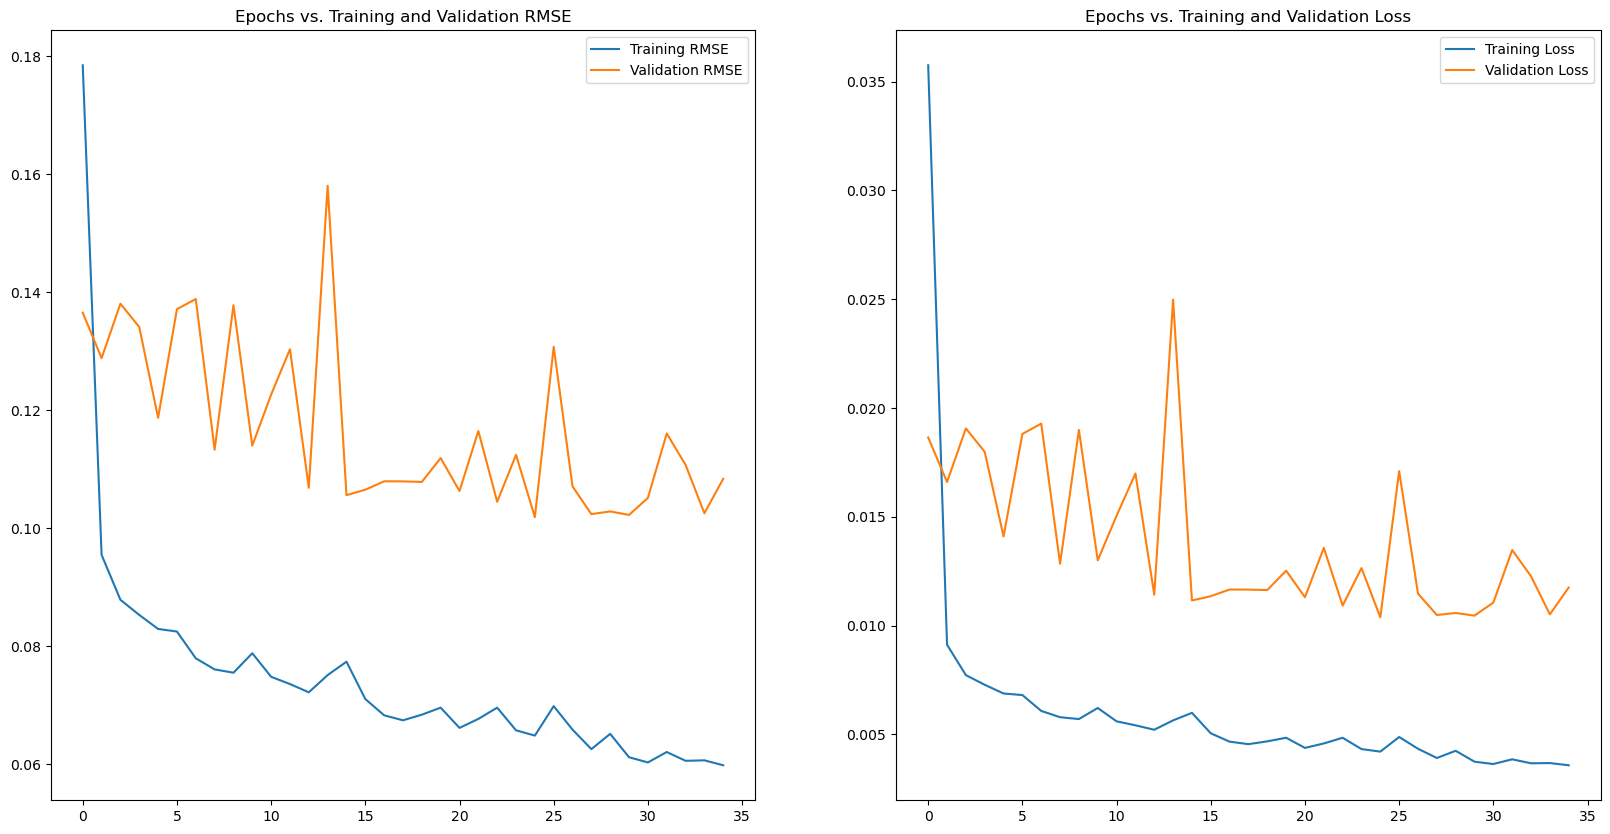

In [129]:
plot_model_rmse_and_loss(history)

In [148]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of day ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

6/6 [==============================] - 0s 2ms/step
RMSE of day ahead electricity price multivariate CNN forecast: 13.051


In [263]:
cv_end_idx

1396

1/1 [==============================] - 0s 58ms/step


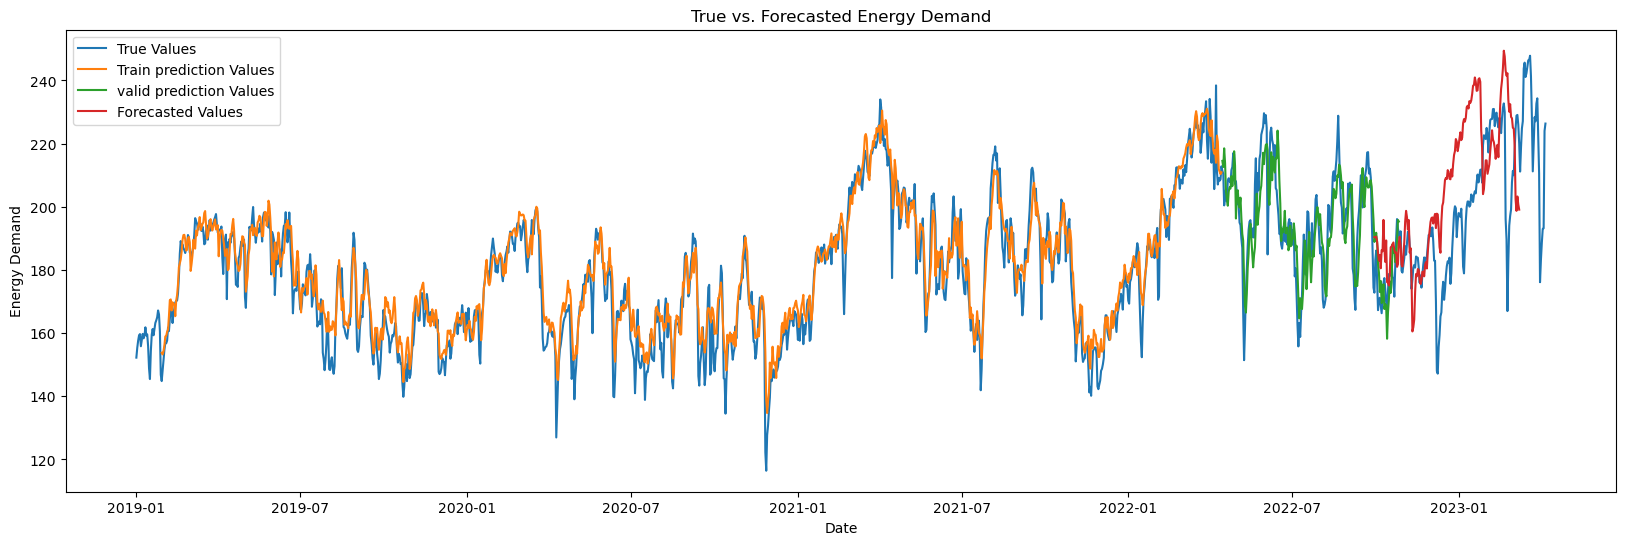

In [267]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

train_forecast = multivariate_cnn.predict(X_train)

train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

valid_forecast = multivariate_cnn.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)
n_features = 4

X_test2 = X[1530:1558,:].reshape(1,past_history,n_features)

multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast_unseen = multivariate_cnn.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, true_values[:1559], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_cnn_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN- LSTM**

In [138]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu'),
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu'),
    LSTM(150, return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(50),
    Flatten(),
    Dense(100),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [139]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
37/37 [==============================] - 9s 107ms/step - loss: 0.0392 - root_mean_squared_error: 0.1879 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1521
Epoch 2/120
37/37 [==============================] - 2s 62ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1580
Epoch 3/120
37/37 [==============================] - 2s 62ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1563
Epoch 4/120
37/37 [==============================] - 2s 63ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1477
Epoch 5/120
37/37 [==============================] - 2s 63ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1624
Epoch 6/120
37/37 [==============================] - 3s 69ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053 - val_loss: 0.0196 - val

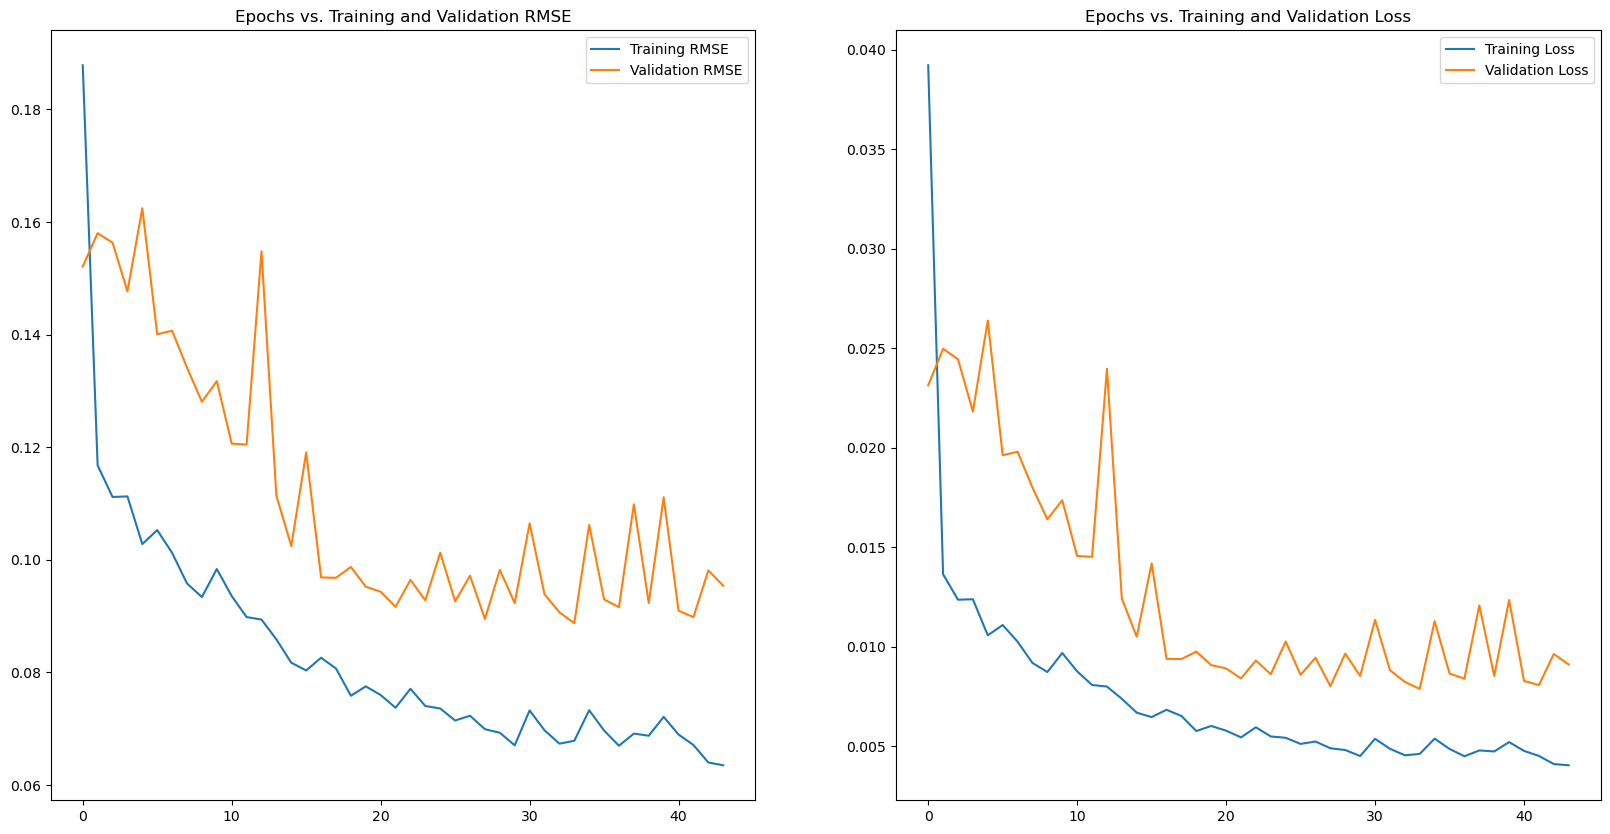

In [150]:
plot_model_rmse_and_loss(history)

In [152]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

6/6 [==============================] - 1s 15ms/step
RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: 11.57


1/1 [==============================] - 1s 901ms/step


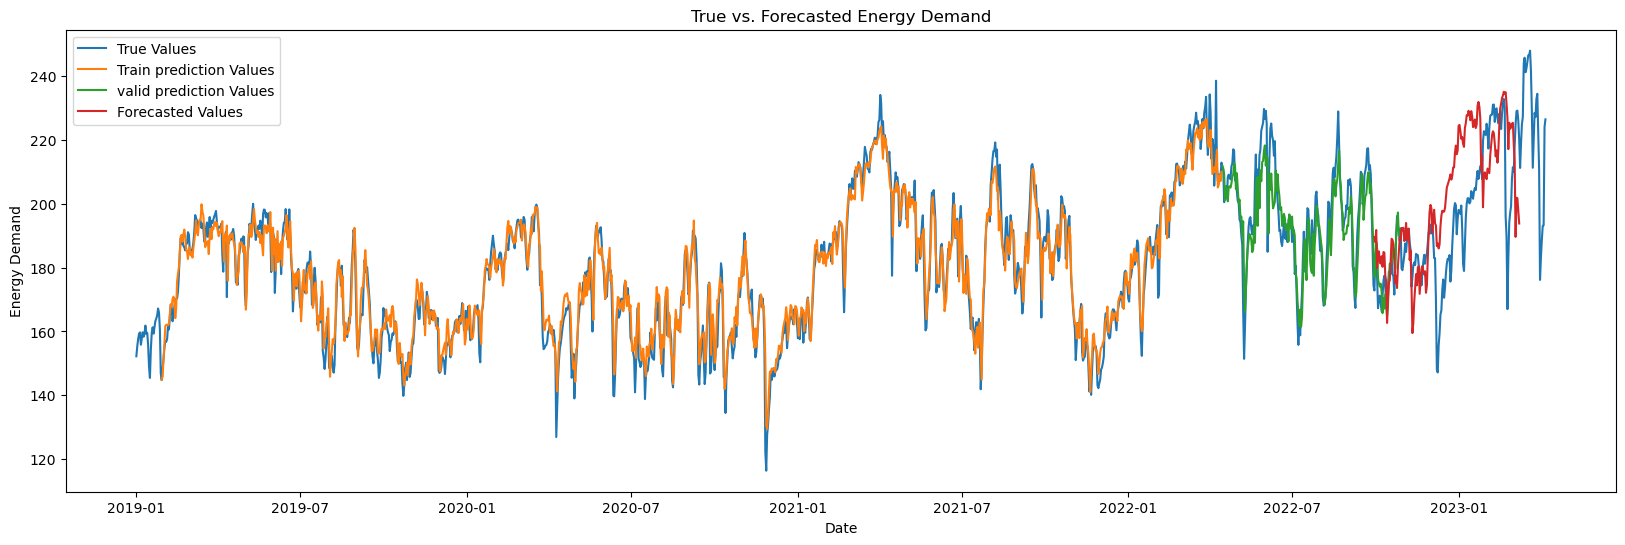

In [266]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

train_forecast = multivariate_cnn_lstm.predict(X_train)

train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

valid_forecast = multivariate_cnn_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

X_test2 = X[1530:1558,:].reshape(1,28,4)

multivariate_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast_unseen = multivariate_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, true_values[:1559], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_cnn_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


In [110]:
merged_df.tail()

,Energy Required (MU),Tmax,Tmin,Rain
2023-04-03,188.591,35.240079,19.384070,0.000000
2023-04-04,193.000,35.972310,25.309858,0.392332
2023-04-05,193.201,33.934335,25.928193,2.541572
2023-04-06,224.030,38.145824,27.398606,0.000000
2023-04-07,226.349,39.622750,27.568079,0.000000


# **Time Distributed MLP**

In [154]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [155]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
37/37 [==============================] - 2s 12ms/step - loss: 0.0290 - root_mean_squared_error: 0.1618 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 2/120
37/37 [==============================] - 0s 9ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 3/120
37/37 [==============================] - 0s 8ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 4/120
37/37 [==============================] - 0s 8ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 5/120
37/37 [==============================] - 0s 8ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 6/120
37/37 [==============================] - 0s 11ms/step - loss: 0.0061 - root_mean_squared_error: 0.0784 - val_loss: 0.0116 - val_root

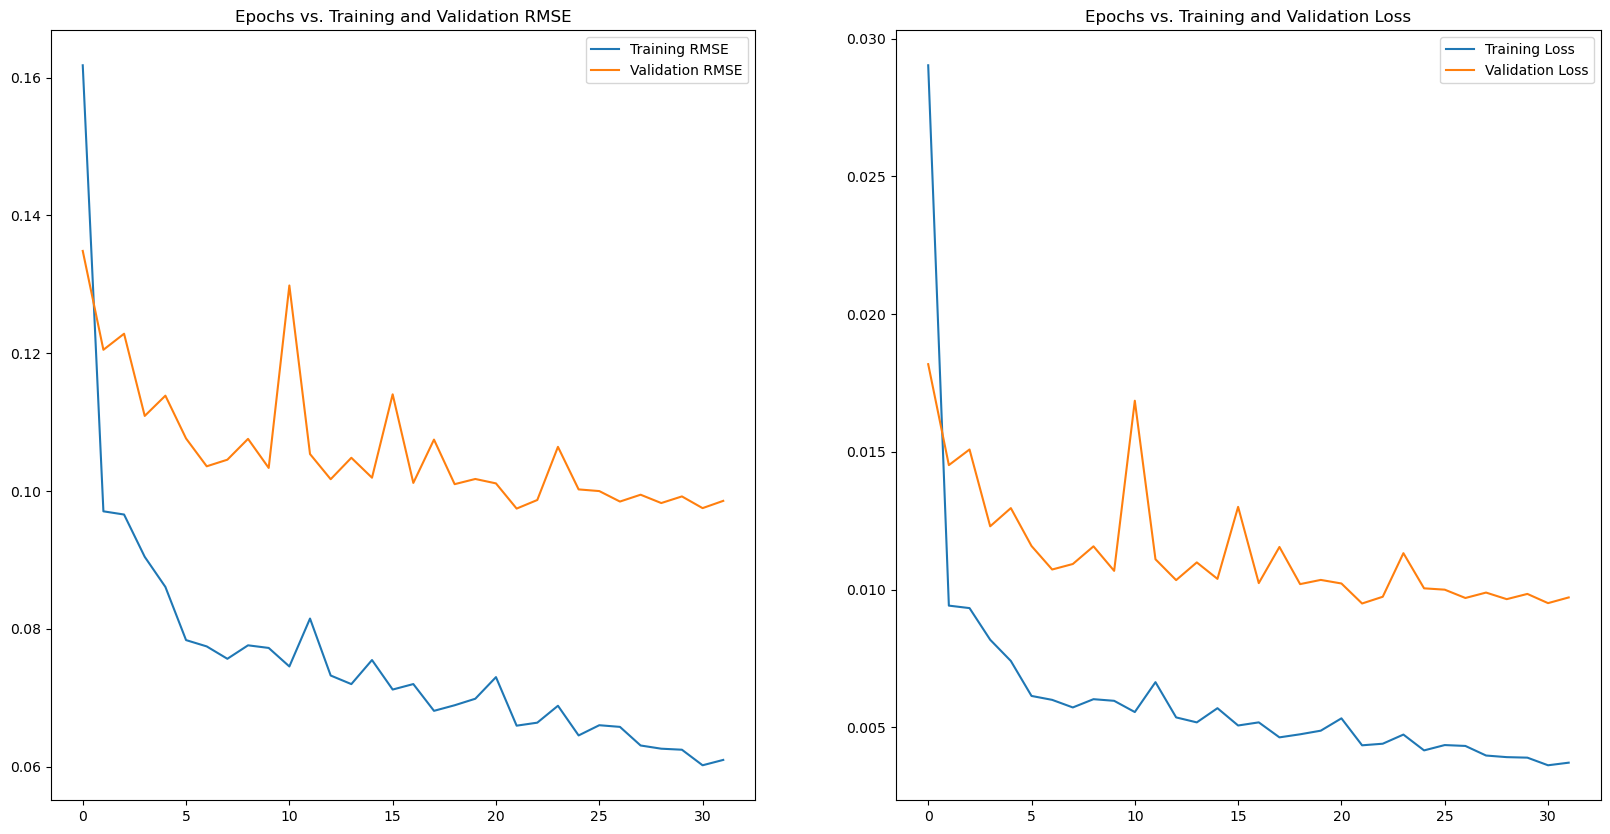

In [156]:
plot_model_rmse_and_loss(history)

In [157]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of day-ahead power demand multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

6/6 [==============================] - 0s 2ms/step
RMSE of day-ahead power demand multivariate MLP forecast: 12.685


1/1 [==============================] - 0s 78ms/step


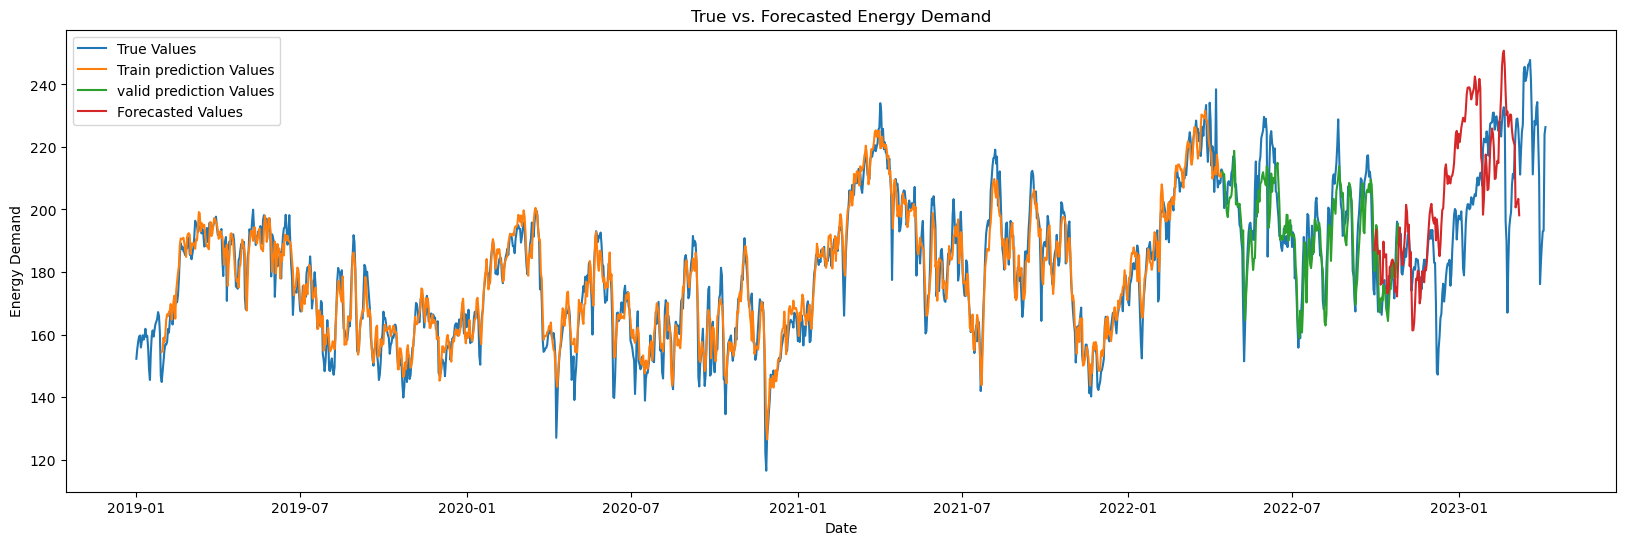

In [242]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

train_forecast = multivariate_mlp.predict(X_train)

train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

valid_forecast = multivariate_mlp.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

X_test2 = X[1530:1558,:].reshape(1,28,4)

multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast_unseen = multivariate_mlp.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, true_values[:1559], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_mlp_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Encoder Decoder**

In [159]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [160]:
history = encoder_decoder.fit(train, epochs=120,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/120
37/37 [==============================] - 4s 34ms/step - loss: 0.0371 - root_mean_squared_error: 0.1821 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 2/120
37/37 [==============================] - 1s 22ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1202
Epoch 3/120
37/37 [==============================] - 1s 22ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 4/120
37/37 [==============================] - 1s 21ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 5/120
37/37 [==============================] - 1s 22ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 6/120
37/37 [==============================] - 1s 21ms/step - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0137 - val_

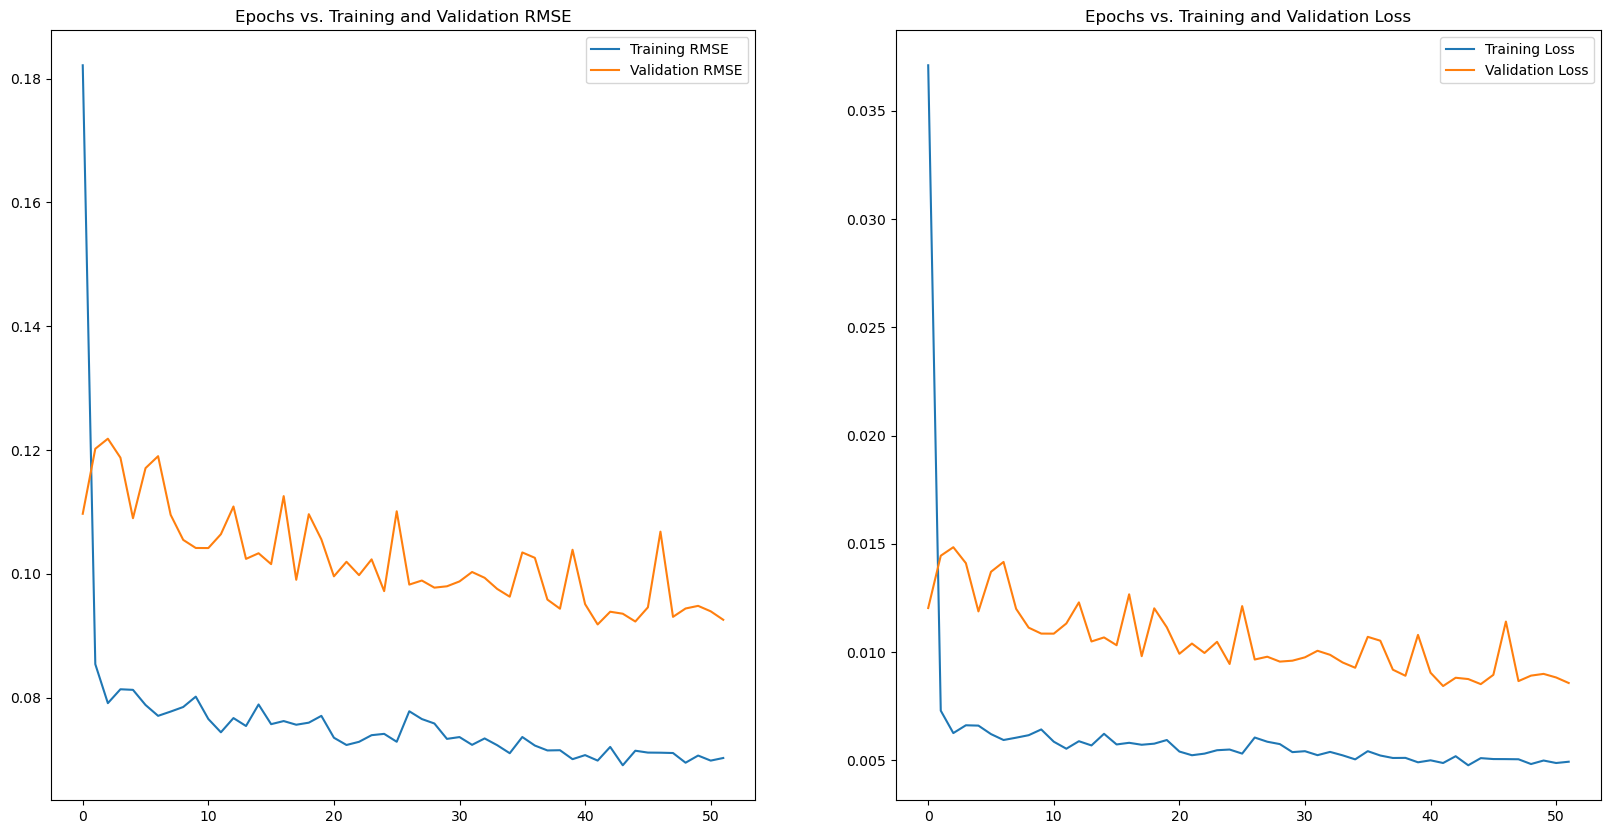

In [161]:
plot_model_rmse_and_loss(history)

In [162]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of day ahead power demand Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

6/6 [==============================] - 0s 6ms/step
RMSE of day ahead power demand Encoder-Decoder forecast: 11.623


1/1 [==============================] - 0s 245ms/step


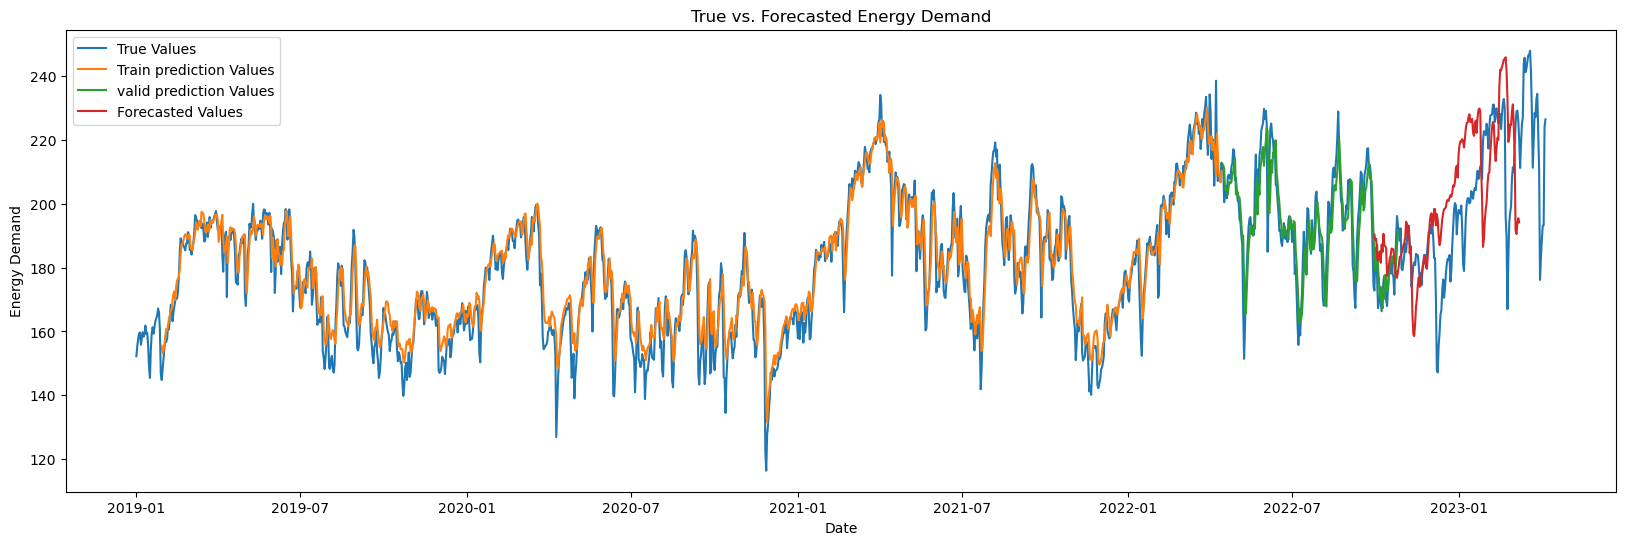

In [244]:
# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:1559]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[1368:1529]
dates_unseen = merged_df.index[1529:1559]

train_forecast = encoder_decoder.predict(X_train)

train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

valid_forecast = encoder_decoder.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

X_test2 = X[1530:1558,:].reshape(1,28,4)

encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast_unseen = encoder_decoder.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)


# Extend the index to add one more day for unseen predictions
last_date = merged_df.index[-1]
future_date = last_date + pd.DateOffset(days=1)
extended_index = merged_df.index.append(pd.Index([future_date]))

import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values
 # Replace X_test with your test data



# Plotting the true values and forecasted values
plt.figure(figsize=(20, 6))
plt.plot(dates_true, true_values[:1559], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted,encoder_decoder_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


In [119]:
import pandas as pd
import datetime

# Function to predict the next demand based on past twenty-eight values
def predict_demand(input_date, df):
    # Convert the input date to datetime object
    input_date = datetime.datetime.strptime(input_date, '%d-%B-%Y')

    # Check if the input date is within the valid range (4 March 2023 to 4 July 2023)
    valid_start_date = datetime.datetime(2023, 4, 4)
    valid_end_date = datetime.datetime(2023, 5, 4)
    if input_date < valid_start_date or input_date > valid_end_date:
        print("Invalid input date. Please enter a date between 4 March 2023 and 4 July 2023.")
        return None

    # Get the past twenty-eight dates from the input date
    past_dates = [input_date - datetime.timedelta(days=i) for i in range(1, 29)]
    print(len(past_dates))
    # Retrieve the corresponding demand values for the past dates from your dataframe
    past_demand_values = merged_df.loc[past_dates]

    # Prepare the input data for your time series model using the past demand values
    input_data = past_demand_values.values.flatten()
    
    # TODO: Use your time series model to predict the next demand based on the input data
    input_data = input_data.reshape(1, past_history,n_features)
    print(input_data.shape)
    model =tf.keras.models.load_model('multivariate_lstm.h5')
    predicted_demand = model.predict(input_data)
        # Determine the date for which the demand is being predicted
    predicted_date = input_date + datetime.timedelta(days=1) 
    # TODO: Return the predicted demand for the next day
    return predicted_demand,predicted_date

# Example usage
# Assuming your dataframe is named 'df' with dates as the index
input_date = input("Enter a date (DD-Month-YYYY): ")
predicted_demand, predicted_date = predict_demand(input_date, merged_df)
print("Predicted demand for", predicted_date.strftime("%d-%B-%Y") + ":", predicted_demand)


Enter a date (DD-Month-YYYY):  04-April-2023


28
(1, 28, 4)
1/1 [==============================] - 0s 428ms/step
Predicted demand for 05-April-2023: [[10.478439]]


# **GluonTS**

In [ ]:
!pip install mxnet
!pip install gluonts

In [ ]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator